In [99]:
#Импорт всех необходимых библиотек
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import xgboost
import catboost
from sklearn.metrics import r2_score
import pandas as pd
import seaborn as sns
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import re
import ast

In [100]:
data = pd.read_csv('data.csv')
len_1 = len(data)
#Посмотрим на данные
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [101]:
#Посмотрим столбцы
print(data.columns)

Index(['status', 'private pool', 'propertyType', 'street', 'baths',
       'homeFacts', 'fireplace', 'city', 'schools', 'sqft', 'zipcode', 'beds',
       'state', 'stories', 'mls-id', 'PrivatePool', 'MlsId', 'target'],
      dtype='object')


In [102]:
data = data.drop(['MlsId', 'mls-id', 'private pool'], axis = 1)

In [103]:
#Процентное отношение пропущеных данных ко всем
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data)

               Total   Percent
PrivatePool   336874  0.893127
fireplace     274070  0.726620
stories       150715  0.399578
baths         106338  0.281925
beds           91282  0.242009
sqft           40577  0.107579
status         39918  0.105831
propertyType   34733  0.092085
target          2481  0.006578
city              34  0.000090
street             2  0.000005
state              0  0.000000
zipcode            0  0.000000
schools            0  0.000000
homeFacts          0  0.000000


In [104]:
#Для начала, нужно максимально обработать все столбцы
#Посмотрим на пример данных в PrivatePool
print(data['PrivatePool'].unique())

[nan 'yes' 'Yes']


In [105]:
def func_pool(x):
    if type(x) != int:
        x = x.replace(x, '1')
    return int(x)

data['PrivatePool'] = data['PrivatePool'].fillna(0).apply(func_pool)

In [106]:
print(data['fireplace'].unique())

['Gas Logs' nan 'yes' ...
 'Ceiling Fan, Fire Sprinkler System, Storage, Utility Connection'
 'Fireplace-Gas, Fireplace-Wood, Patio, Walk-in Closet'
 'Ceiling Fan, SMAPL, Utility Connection, Walk-In Closets']


In [107]:
def func_fire(x):
    if type(x) != int:
        x = x.replace(x, '1')
    return int(x)

data['fireplace'] = data['fireplace'].fillna(0).apply(func_fire)

In [108]:
#Рассмотрим stories
print(data['stories'].unique())

[nan '2.0' '1.0' '3.0' 'One' '2' 'Multi/Split' '4.0' '0.0' '0' 'One Level'
 '1' '9.0' '3' '1 Level, Site Built' 'One Story' '3.00' '1.00' '14.0'
 'Two' '3+' '1 Story' '5.0' '2 Story' 'Ranch/1 Story' 'Condominium'
 'Stories/Levels' '7.0' '2 Level, Site Built' '2 Level' '15'
 '3 Level, Site Built' '4' '22.0' '2.00' '6.0' '1.0000' 'Lot' '3 Story'
 'Three Or More' '1.5' '1 Level' 'Two Story or More'
 'Site Built, Tri-Level' '54.0' '23' 'Farm House' '8.0' '16.0' '1.50' '18'
 '9' '21' '8' '12.0' 'Split Level w/ Sub' '11.0' '18.0' '1.5 Stories' '7'
 '11' 'Townhouse' '12' '21.0' '16' '1.5 Story/Basement' '28.0'
 'Traditional' '2.5 Story' '17' '2.0000' '63.0' 'Acreage'
 'Ground Level, One' '6' 'Split Foyer' '2 Stories' '27.0' '19.0' '2.50'
 '1.30' '2 Story/Basement' 'Split Level' '1.5 Story' '1.5 Level'
 '2 Or More Stories' '1 Level, Condo, Site Built' '15.0' '20' '1.5000'
 '4.00' '1 Story Basement' '5' 'Multi-Level' '17.0' 'Other Multi-unit'
 'Ranch' 'Tri-Level' '13.0' '1 Story/Ranch' '51.0' '

In [109]:
#Обработка stories

def func_stor(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if (len(x) > 1):
            x = x[0]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return 1
    return int(x)

data['stories'] = data['stories'].fillna(1).apply(func_stor)
data['stories'] = pd.to_numeric(data['stories'])

In [110]:
print(data['baths'].unique())

['3.5' '3 Baths' '2 Baths' '8 Baths' nan '2' '3' 'Bathrooms: 2' '1,750'
 '4 Baths' '2 ba' 'Bathrooms: 5' '1,000' '7 Baths' '2.0' '3.0'
 'Bathrooms: 1' '4.0' '2.1 Baths' '2.5 Baths' '1' 'Bathrooms: 3' '4.5'
 '6 Baths' 'Bathrooms: 4' '3 ba' '5' '2,500' '5.5 Baths' '1.0' '5 Baths'
 '1.5' '4' '~' '2.5' '4,000' '3.5 Baths' '2,000' '3,000' '8.0' '1 ba'
 '3.5 ba' '0' '5.0' '1,500' '7.0' '1,250' '9 Baths' '2,250' '6.0'
 '12 Baths' '5.5' '3,500' '1.5 Baths' '2,750' 'Bathrooms: 6' '4.5 Baths'
 '750' '5.5+' '6' '10 Baths' '6 ba' 'Bathrooms: 19' '10.0' '1.5 ba' '4 ba'
 '12 ba' '2.5+' '8' '7.5+' 'Bathrooms: 10' '0 / 0' 'Sq. Ft. ' '5 ba'
 '4.5+' '18 Baths' '-- baths' 'Bathrooms: 7' '7' '18' '3.5+' '1.5+'
 '11 Baths' '5,000' '1.75 Baths' '9' '12.0' '1.1 Baths' '6.5'
 'Bathrooms: 8' '10' '19 Baths' 'Bathrooms: 9' '16 Baths' '13 Baths'
 'Bathrooms: 13' '14' '9.0' '8.5+' '7 ba' '12' '2.5 ba' 'Bathrooms: 12'
 '17' 'Bathrooms: 241' '16.0' '10.5+' '8 ba' '6.5+' '6.5 Baths' '14 Baths'
 '7,500+' '7.5' '11.0'

In [111]:
def func_bath(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if (len(x) > 1):
            x = x[0]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return 1
    return int(x)

data['baths'] = data['baths'].fillna(1).apply(func_bath)

In [112]:
print(data['beds'].unique())

['4' '3 Beds' '5 Beds' ... '9,565 sqft' '1.74 acres' '8,479 sqft']


In [113]:
def func_bed(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if (len(x) > 1):
            x = x[0]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return 1
    return int(x)

data['beds'] = data['beds'].fillna(1).apply(func_bed)

In [114]:
print(data['status'].unique())

['Active' 'for sale' nan 'New construction' 'New' 'For sale' 'Pending' 'P'
 'Active/Contingent' 'Pre-foreclosure / auction' ' / auction'
 'Under Contract' 'Under Contract   Showing' 'Pre-foreclosure'
 'Under Contract Backups' 'foreclosure' 'Active Under Contract'
 'Foreclosed' 'Option Pending' 'Under Contract Show' 'for rent' 'Auction'
 'A Active' 'Contingent' 'Pending   Continue To Show' 'Price Change'
 'Back on Market' 'Active Option' 'Foreclosure' 'recently sold'
 'Coming soon: Nov 21.' 'Contingent Finance And Inspection'
 'Coming soon: Dec 4.' 'P Pending Sale' 'Coming soon: Nov 23.'
 'Active With Contingencies' 'Pending Ab' 'Pf' 'Contingent Show'
 'Contract P' 'Contingent Take Backup' 'Apartment for rent'
 'Backup Contract' 'Option Contract' 'Pending Continue To Show' 'pending'
 'Pending Inspection' 'Active Option Contract' 'C' 'Auction - Active'
 'Contingent   Show' 'Pi' 'Due Diligence Period'
 'Contract Contingent On Buyer Sale' 'U Under Contract'
 'Coming soon: Nov 29.' 'Coming 

In [115]:
print(data['propertyType'].unique())

['Single Family Home' 'single-family home' 'lot/land' ...
 'Cabin/Lodge, Contemporary, Converted Barn, Cottage, Loft with Bedrooms, Log Home, Post & Beam'
 'Lake House, Single Detached, Tudor'
 'Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit']


In [116]:
data = data.drop(['propertyType', 'status'], axis=1)

In [117]:
data = data.drop(data.loc[data['city'].isnull()].index)
data = data.drop(data.loc[data['street'].isnull()].index)

In [118]:
data = data.drop(data.loc[data['target'].isnull()].index)

In [119]:
data = data.drop(data.loc[data['sqft'].isnull()].index)

In [120]:
print(data.isnull().sum().max())

0


In [121]:
data.head()

,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,PrivatePool,target
0,240 Heather Ln,3,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",1,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,1,0,"$418,000"
1,12911 E Heroy Ave,3,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",0,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3,WA,2,0,"$310,000"
2,2005 Westridge Rd,2,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",1,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3,CA,1,1,"$2,895,000"
3,4311 Livingston Ave,8,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",1,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5,TX,3,0,"$2,395,000"
5,1624 S Newkirk St,1,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",0,Philadelphia,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897 sqft,19145,2,PA,2,0,"$209,000"


In [122]:
#Приведем target и sqft к int

def func_cost(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if len(x) > 2:
            x = x[0] + x[1] + x[2]
        elif len(x) > 1:
            x = x[0] + x[1]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return np.nan
    return int(x)

def func_area(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if len(x) > 1:
            x = x[0] + x[1]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return np.nan
    return int(x)

data['sqft'] = data['sqft'].apply(func_area)
data['target'] = data['target'].apply(func_cost)

In [123]:
data = data.drop(['city', 'street', 'zipcode'], axis = 1)

In [124]:
print(data['homeFacts'][0])
print(type(data['homeFacts'][0]))

{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}
<class 'str'>


In [125]:
def data_func1(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][0].get('factValue')

def data_func2(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][1].get('factValue')

def data_func3(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][2].get('factValue')

def data_func4(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][3].get('factValue')

def data_func5(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][4].get('factValue')

def data_func6(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][5].get('factValue')

def data_func7(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][6].get('factValue')

data['built'] = data['homeFacts'].apply(data_func1)
data['rebuilt'] = data['homeFacts'].apply(data_func2)
data['heating'] = data['homeFacts'].apply(data_func3)
data['cooling'] = data['homeFacts'].apply(data_func4)
data['parking'] = data['homeFacts'].apply(data_func5)
data['lotsize'] = data['homeFacts'].apply(data_func6)
data['price'] = data['homeFacts'].apply(data_func7)
# built - год постройки
# rebuilt - год реновации
# heating - отопление
# cooling - кондиционер
# parking - паркинг
# lotsize - площадь участка
# price - цена за 1 sqft

In [126]:
print(data['schools'][0])
print(type(data['schools'][0]))

[{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'], 'data': {'Distance': ['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5 mi', '12.6 mi', '2.7 mi', '3.1 mi'], 'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']}, 'name': ['Southern Pines Elementary School', 'Southern Middle School', 'Pinecrest High School', 'Southern Pines Primary School', "Crain's Creek Middle School", 'Union Pines High School', 'Episcopal Day Private School', 'Calvary Christian Private School']}]
<class 'str'>


In [127]:
def data_func8(x):
    m = []
    a = ast.literal_eval(x)
    a = dict(a[0])
    k = a['data'].get('Distance')
    for i in k:
        h = re.findall(r'\d+',i)
        if len(h) == 0:
            continue
        if len(h) == 1:
            m.append(float(h[0]))
            continue
        d = h[0] + '.' + h[1]
        m.append(float(d))
    if len(m) == 0:
        return np.nan
    else:
        return min(m)
    
data['distance'] = data['schools'].apply(data_func8)
data = data.drop(data.loc[data['distance'].isnull()].index)
#distance - дистанция до ближайшей школы

In [128]:
data = data.drop(['homeFacts', 'schools'], axis = 1)

In [129]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.head(7))

         Total   Percent
lotsize  24920  0.075289
rebuilt  23135  0.069896
price    18542  0.056020
sqft       810  0.002447
built      569  0.001719
parking    543  0.001641
cooling    543  0.001641


In [130]:
#Обработаем parking, cooling, heating
print(data['cooling'].unique())

['' 'Central' 'Central Air' ...
 'Central Air, Electric Hot Air, Gas (Hot Air), Heat Pump for A/C, Heat Pump for Heat, Multi-Zone A/C, Multi-Zone Heat, Natural Gas'
 '90%+ High Efficiency, Ductless HP-Mini Split, Tankless Water Heater'
 'Central A/C (Gas), Central Heat (Gas), Heat Pump']


In [131]:
def func_cool(x):
    if x == '':
        return 0
    return 1

data['cooling'] = data['cooling'].apply(func_cool)

In [132]:
print(data['heating'].unique())

['Central A/C, Heat Pump' '' 'Forced Air' ...
 'Electric Furnace, Electric Heat Pump'
 'Floor Furnace, Wall Electric, Wall Gas'
 'Baseboard, Hot Water, Programmable Thermostat, Radiant Floor']


In [133]:
def func_heat(x):
    if x == '':
        return 0
    return 1

data['heating'] = data['heating'].apply(func_heat)

In [134]:
print(data['parking'].unique())

['' 'Attached Garage' 'Detached Garage' ... 'Basement, Detached'
 'Paved Driveway, Off Street, Detached Garage'
 'Deed Restrictions, Fitness, Gated Community, Golf Carts OK, No Truck/RV/Motorcycle Parking, Pool, Special Community Restrictions']


In [135]:
def func_park(x):
    if x == '':
        return 0
    return 1

data['parking'] = data['parking'].apply(func_park)

In [136]:
def func_built(x):
    x = re.findall(r'\d+',x)
    if len(x) > 1:
        x = x[0] + x[1]
    elif len(x) == 1:
        x = x[0]
    if not x:
        return np.nan
    return int(x)

data = data.drop(data.loc[data['built'].isnull()].index)

data['built'] = data['built'].apply(func_built)

data = data.drop(data.loc[data['built'].isnull()].index)

In [137]:
data['rebuilt'] = data['rebuilt'].fillna(0)
def func_rebuilt(row):
    if row['rebuilt'] == 0:
        return row['built']
    if row['rebuilt'] == '':
        return row['built']
    return row['rebuilt']
        
data['rebuilt'] = data.apply(lambda row: func_rebuilt(row), axis=1)

In [138]:
data = data.drop(data.loc[data['lotsize'].isnull()].index)
data = data.drop(data.loc[data['price'].isnull()].index)
data.head()

,baths,fireplace,sqft,beds,state,stories,PrivatePool,target,built,rebuilt,heating,cooling,parking,lotsize,price,distance
1,3,0,1947.0,3,WA,2,0,310000,2019.0,2019,0,0,0,5828 sqft,$159/sqft,1.01
2,2,1,3000.0,3,CA,1,1,2895000,1961.0,1967,1,1,1,"8,626 sqft",$965/sqft,1.19
3,8,1,6457.0,5,TX,3,0,2395000,2006.0,2006,1,1,1,"8,220 sqft",$371/sqft,0.10
6,1,0,1507.0,1,FL,1,0,181500,2006.0,2006,1,1,0,"4,996 Sq. Ft.",$120 / Sq. Ft.,0.80
8,2,0,3588.0,3,IA,1,0,244900,1970.0,1970,1,1,0,124582,$68,5.60


In [139]:
#Достанем числа из lotsize и price

def func_lot(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if len(x) > 1:
            x = x[0] + x[1]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return np.nan
    return int(x)

data['lotsize'] = data['lotsize'].apply(func_lot)
data['price'] = data['price'].apply(func_lot)
data = data.drop(data.loc[data['lotsize'].isnull()].index)
data = data.drop(data.loc[data['price'].isnull()].index)

In [140]:
top = ['WA', 'NH', 'MN', 'UT', 'VT', 'MD', 'VA', 'MA', 'NE', 'CO', 'WI', 'NJ', 'FL', 'IA', 'ND', 'ID']
mid = ['GA', 'NC', 'CA', 'SD', 'CT', 'KS', 'DE', 'HI', 'NY', 'RI', 'OR', 'MO', 'MT', 'TN', 'WY', 'ME']

def state(x):
    if x in top:
        return 2
    if x in mid:
        return 1
    return 0

data['state'] = data['state'].apply(state)

In [141]:
print(data.isnull().sum().max())

0


In [142]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.head(7))

          Total  Percent
distance      0      0.0
price         0      0.0
lotsize       0      0.0
parking       0      0.0
cooling       0      0.0
heating       0      0.0
rebuilt       0      0.0


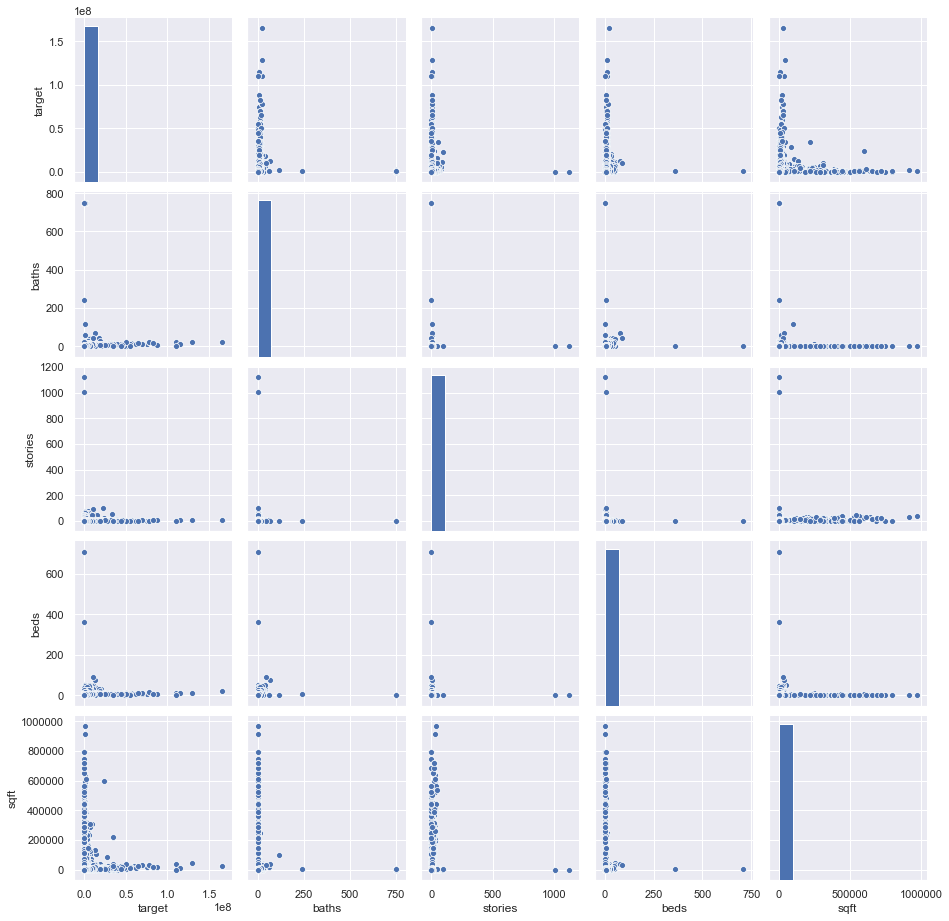

In [143]:
import matplotlib.pyplot as plt
sns.set()
cols = ['target', 'baths', 'stories', 'beds', 'sqft']
sns.pairplot(data[cols], size = 2.5)
plt.show();

In [144]:
data = data[data['sqft'] < 1000000]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


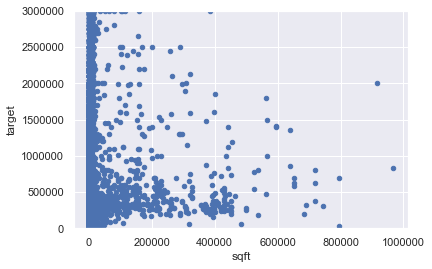

In [145]:
var = 'sqft'
dat = pd.concat([data['target'], data[var]], axis=1)
dat.plot.scatter(x=var, y='target', ylim=(0,3000000));

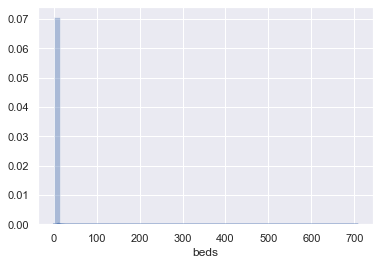

In [146]:
data = data[data['sqft'] < 500000]
sns.distplot(data['beds'])

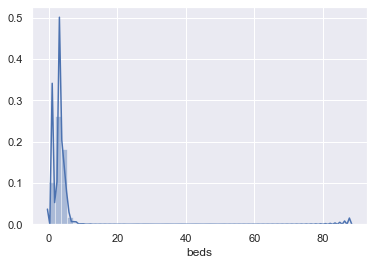

In [147]:
data = data[data['beds'] < 100]
sns.distplot(data['beds'])

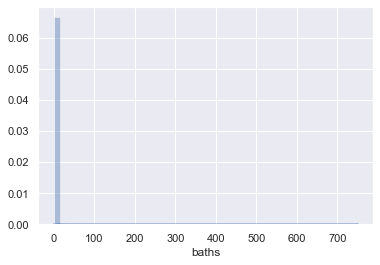

In [148]:
data = data[data['beds'] < 10]
sns.distplot(data['baths'])

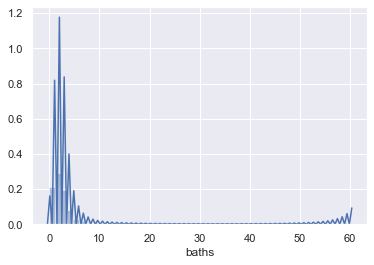

In [149]:
data = data[data['baths'] < 100]
sns.distplot(data['baths'])

In [150]:
data = data[data['baths'] < 10]

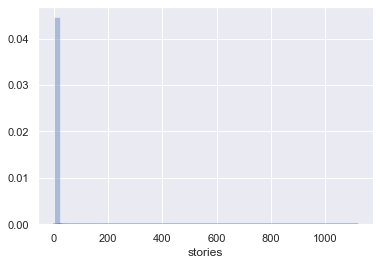

In [151]:
sns.distplot(data['stories'])

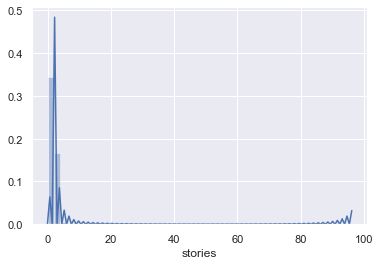

In [152]:
data = data[data['stories'] < 100]
sns.distplot(data['stories'])

In [153]:
data = data[data['stories'] < 15]
len_2 = len(data)
deleted = len_1 - len_2
data.to_csv('model.csv', index=False)
print(deleted)

153022


In [189]:
data = pd.read_csv('model.csv')
X = data.drop('target', axis = 1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=21)

Протестируем работу различных алгоритмов


In [190]:
xg = xgboost.XGBRegressor()
scores = cross_val_score(xg, X_train, y_train, cv=cv, n_jobs=-1, scoring='r2')
print("Xgboost: {}/{}".format(scores.mean(), scores.std()))

Xgboost: 0.9384784063067707/0.015491786795164325


In [182]:
lr = LinearRegression()
scores = cross_val_score(lr, X_train, y_train, cv=cv, n_jobs=-1, scoring='r2')
print("LinearRegression: {}/{}".format(scores.mean(), scores.std()))

LinearRegression: 0.1641851021213773/0.005373698994263434


In [183]:
xg = catboost.CatBoostRegressor()
scores = cross_val_score(xg, X_train, y_train, cv=cv, n_jobs=-1, scoring='r2')
print("catboost: {}/{}".format(scores.mean(), scores.std()))

catboost: 0.8584302572031515/0.02185070565011511


In [184]:
gb = GradientBoostingRegressor(random_state=21)
scores = cross_val_score(gb, X_train, y_train, cv=cv, n_jobs=-1, scoring='r2')
print("GradientBoosting: {}/{}".format(scores.mean(), scores.std()))

GradientBoosting: 0.9527627714532737/0.007606243981308374


In [185]:
kn = KNeighborsRegressor()
scores = cross_val_score(kn, X_train, y_train, cv=cv, n_jobs=-1, scoring='r2')
print("Kneighbors: {}/{}".format(scores.mean(), scores.std()))

Kneighbors: 0.8224631664937286/0.05381744318122403


In [186]:
rf = RandomForestRegressor(random_state=21)
scores = cross_val_score(rf, X_train, y_train, cv=cv, n_jobs=-1, scoring='r2')
print("RandomForest: {}/{}".format(scores.mean(), scores.std()))

RandomForest: 0.93753402638366/0.01568001583783868


In [233]:
dt = DecisionTreeRegressor(random_state=21)
scores = cross_val_score(dt, X_train, y_train, cv=cv, n_jobs=-1, scoring='r2')
print("DecisionTree: {}/{}".format(scores.mean(), scores.std()))

DecisionTree: 0.899513367801713/0.01452032097774529

RandomForest, GradientBoosting и xgboost дают лучшие результаты
Подберем параметры каждому


In [209]:
alg_frst_model = xgboost.XGBRegressor(random_state=21)
alg_frst_params = [{
    "n_estimators": [20, 30, 40],
    "min_samples_split": [1, 2, 3],
    "min_samples_leaf": [1, 2, 3],
    "max_depth": [3, 4, 5]
}]
alg_frst_grid = GridSearchCV(alg_frst_model, alg_frst_params, cv=cv, refit=True, n_jobs=-1)
alg_frst_grid.fit(X_train, y_train)
alg_frst_best = alg_frst_grid.best_estimator_
print("xgboost: {} with params {}"
      .format(alg_frst_grid.best_score_, alg_frst_grid.best_params_))

xgboost: 0.9434290342430501 with params {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 40}


In [210]:
alg_scnd_model = RandomForestRegressor(random_state=21)
alg_scnd_params = [{
    "n_estimators": [25, 50, 75],
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2, 3],
    "max_depth": [10, 11, 12]
}]
alg_scnd_grid = GridSearchCV(alg_scnd_model, alg_scnd_params, cv=cv, refit=True, n_jobs=-1)
alg_scnd_grid.fit(X_train, y_train)
alg_scnd_best = alg_scnd_grid.best_estimator_
print("random forest: {} with params {}"
      .format(alg_scnd_grid.best_score_, alg_scnd_grid.best_params_))

random forest: 0.9404996639412858 with params {'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50}


In [211]:
alg_thrd_model = GradientBoostingRegressor(random_state=21)
alg_thrd_params = [{
    "n_estimators": [25, 50, 75],
    "min_samples_split": [1, 2, 3],
    "min_samples_leaf": [1, 2, 3],
    "max_depth": [2, 3, 4]
}]
alg_thrd_grid = GridSearchCV(alg_thrd_model, alg_thrd_params, cv=cv, refit=True, n_jobs=-1)
alg_thrd_grid.fit(X_train, y_train)
alg_thrd_best = alg_thrd_grid.best_estimator_
print("gradient boosting: {} with params {}"
      .format(alg_thrd_grid.best_score_, alg_thrd_grid.best_params_))

gradient boosting: 0.9519270237061478 with params {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 75}


In [213]:
#Обучим модели
rf = RandomForestRegressor(random_state=21, max_depth = 12, min_samples_leaf = 3, 
                           min_samples_split = 2, n_estimators = 50)

xg = xgboost.XGBRegressor(max_depth = 3, min_samples_leaf = 1, 
                          min_samples_split = 1, n_estimators = 40, random_state = 21)

gb = GradientBoostingRegressor(max_depth = 4, min_samples_leaf = 1, 
                               min_samples_split = 2, n_estimators = 75, random_state = 21)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)

xg.fit(X_train, y_train)
xg_pred = xg.predict(X_test)

Соберем ensemble


In [232]:
y_pred = 0.2*rf_pred + 0.6*gb_pred + 0.2*xg_pred

Сохраним результат


In [ ]:
submission = pd.DataFrame({"target": y_pred})
submission.to_csv("submission.csv", index=False)